In [1]:
import numpy as np 
import pandas as pd
import heapq
import warnings
from pandas.core.common import SettingWithCopyWarning
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sklearn
from sklearn.cluster import KMeans
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from scipy import spatial


import tensorflow as tf
import tensorflow_hub as hub
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
# model = hub.load(module_url)
# def embed(input):
#   return model(input)

# nltk.download('punkt')
# nltk.download('stopwords')

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from pprint import pprint

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
sns.set_style("darkgrid")
# from google.colab import drive
# drive.mount('/content/drive')

## Loading datasets:
In order to minimize cultural differences, only movies that **USA** has been on of their production countries have been chosen. Also, all movies without a box office record (**usa gross** or domestic gross) have been droped.
Lastly, only movies **after 1990** have been considered for this task

In [2]:
movie_df = pd.read_csv('imdb_movies.csv', low_memory=False)
rating_df = pd.read_csv('imdb_ratings.csv')
movie_df = movie_df[movie_df['country'].str.contains('USA')]
movie_df = movie_df[movie_df.u_gross_money.notnull()]
movie_df = movie_df[movie_df['title_year'] >= 1990]
movie_df.set_index('movie_id', inplace=True)

In [3]:
len(movie_df)

10231

## Feature engineering:

#### Checking available columns and removing unnecessary ones:

In [4]:
movie_df.columns

Index(['name', 'org_name', 'date', 'title_year', 'point', 'point_volume',
       'metascore', 'user_reviews', 'critic_reviews', 'director', 'writer',
       'story_line', 'cast', 'genres', 'country', 'language', 'budget',
       'world_gross', 'usa_gross', 'runtime', 'production_companies',
       'dollar_budget', 'w_gross_money', 'u_gross_money', 'inflation_coeff',
       'casts_id', 'BlogPage', 'CompPage', 'HomePage', 'release_month',
       'release_day', 'keywords'],
      dtype='object')

We will not be needing **name**, **original name**, **date of release** (since we have year, month and day of release as separate columns), **point_volume**, **metascore**, **budget** (we have dollar_budget column). **World gross** , **usa gross** and their corresponding **w_gross_money** and **u_gross_money** should also be dropped since there's no real value in a algorithm that needs to know movie gross in order to predict it's rating.

**We will use keywords and storyline for Text similary predictor!**

In [5]:
movie_df.drop(['name', 'org_name', 'budget', 'world_gross', 'usa_gross', 'date', 'user_reviews', 'critic_reviews',
              'w_gross_money', 'u_gross_money', 'metascore', 'point_volume', 'casts_id'], axis = 1, inplace=True)
movie_df.head()

,title_year,point,director,writer,story_line,cast,genres,country,language,runtime,production_companies,dollar_budget,inflation_coeff,BlogPage,CompPage,HomePage,release_month,release_day,keywords
movie_id,,,,,,,,,,,,,,,,,,,
tt0035423,2001.0,6.4,James Mangold,"Steven Rogers,James Mangold",Kate and her actor brother live in N.Y. in the...,"Meg Ryan,Liev Schreiber,Natasha Lyonne,Paxton ...","Comedy,Fantasy,Romance",USA,English,118.0,"Konrad Pictures,Miramax",48000000.0,1.470013,0,0,0,12.0,25.0,"time-travel,brooklyn-bridge,bridge,time-travel..."
tt0081145,1993.0,5.4,Dan Curtis,"Stanley Cohen,Richard Tannenbaum","Two ex-cons, Harry (Aiello) and Roy (Pantolian...","Danny Aiello,Joe Pantoliano,David Dukes,Rick A...","Comedy,Crime,Drama,Family",USA,English,NaN,Dan Curtis Productions,NaN,1.800164,0,0,0,10.0,22.0,"kidnapper-kidnapped-relationship,family-relati..."
tt0097115,1990.0,5.7,Christopher Leitch,"Fred Brogger,Mark Brogger","In this version of ""Heidi,"" a young Swiss girl...","Juliette Caton,Nicola Stapleton,Kathryn Ludlow...","Adventure,Drama,Family,War","USA,France",English,NaN,"Epic Productions,Stone Group Pictures",NaN,1.992922,0,0,0,2.0,16.0,"record-player,mountain-climbing,carriage,homes..."
tt0098375,1990.0,4.8,Tobe Hooper,"Tobe Hooper,Tobe Hooper",A young man finds out that his parents had bee...,"Brad Dourif,Jon Cypher,Melinda Dillon,Tegan We...","Horror,Sci-Fi,Thriller",USA,English,97.0,"Black Owl Productions,Project Samson,Skyland S...",5500000.0,1.992922,0,0,0,2.0,23.0,"experiment-gone-wrong,human-experiment,science..."
tt0098966,1990.0,5.5,Emile Ardolino,"Coline Serreau,Sara Parriott",Five happy years after baby Mary's arrival in,"Tom Selleck,Ted Danson,Robin Weisman,Sheila Ha...","Comedy,Drama,Family,Romance",USA,English,104.0,"Touchstone Pictures,Interscope Communications,...",NaN,1.992922,0,0,0,11.0,21.0,"sequel-to-remake,second-part,sequel,girl,numbe..."


#### Adding inflation to budget and scaling:

Also, we should multiply dollar_budget and inflation_coeff and save the result as dolla_budget. If we ignore this part, we are ignoring the fact that 1 dollar in the 20's is equal to about 14 dollars now. Next, we will normalize budget values with a simple standard scaler. This action will be of aid in predicting ratings and reducing noise.

In [6]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
movie_df['dollar_budget'] = movie_df['dollar_budget'] * movie_df['inflation_coeff']
movie_df['dollar_budget'] = min_max_scaler.fit_transform(movie_df[['dollar_budget']])
movie_df.drop(['inflation_coeff'], axis = 1, inplace=True)

#### Looking for NaN values:


In [7]:
movie_df.loc[:, movie_df.isna().any()].columns

Index(['point', 'runtime', 'dollar_budget'], dtype='object')

In [8]:
## drop movies withiout point or dollar_budget values:
movie_df.dropna(subset= ['point', 'dollar_budget'], how='any', inplace=True)

## fillna runtime based on main genre and mean of all other movies:
drama_runtime_mean = movie_df[movie_df['genres'] == 'Drama'].runtime.mean()
doc_runtime_mean = movie_df[movie_df['genres'] == 'Documentary'].runtime.mean()
comedy_runtime_mean = movie_df[movie_df['genres'] == 'Comedy'].runtime.mean()
horror_runtime_mean = movie_df[movie_df['genres'] == 'Horror'].runtime.mean()
movie_df['runtime'] = np.where(movie_df['genres'] == 'Drama', drama_runtime_mean, movie_df['runtime'])
movie_df['runtime'] = np.where(movie_df['genres'] == 'Documentary', doc_runtime_mean, movie_df['runtime'])
movie_df['runtime'] = np.where(movie_df['genres'] == 'Comedy', comedy_runtime_mean, movie_df['runtime'])
movie_df['runtime'] = np.where(movie_df['genres'] == 'Horror', horror_runtime_mean, movie_df['runtime'])
movie_df['runtime'].fillna((movie_df['runtime'].mean()), inplace=True)

#### Label Encoding utility function:

In [9]:
def get_best_columns(base_col, count=10):
    all_contents = list()
    for index, row in movie_df.iterrows():
        content = row[base_col]
        chunks = content.split(',')
        for i in chunks:
          all_contents.append(i)
    c = Counter(all_contents)
    most_common = [key for key, val in c.most_common(count)]
    return most_common

#### Label Encoding Genres:

In [10]:
genres_labels = movie_df['genres'].str.get_dummies(sep=',')
most_common = get_best_columns('genres', 5)
genres_labels = genres_labels[most_common]
movie_df = pd.merge(movie_df, genres_labels, left_index=True, right_index=True)
movie_df.drop(['genres'], axis = 1, inplace=True)

#### Label Encoding Countries:

In [11]:
countries_labels = movie_df['country'].str.get_dummies(sep=',')
most_common = get_best_columns('country')
countries_labels = countries_labels[most_common]
movie_df = pd.merge(movie_df, countries_labels, left_index=True, right_index=True)
movie_df.drop(['country'], axis = 1, inplace=True)

#### Label Encoding Languages:

In [12]:
language_labels = movie_df['language'].str.get_dummies(sep=',')
most_common = get_best_columns('language')
language_labels = language_labels[most_common]
movie_df = pd.merge(movie_df, language_labels, left_index=True, right_index=True)
print(language_labels.mean().sort_values(ascending=False)[0:5])
movie_df.drop(['language'], axis = 1, inplace=True)

English    0.995406
Spanish    0.047984
French     0.045772
German     0.028246
Italian    0.021269
dtype: float64


#### Label Encoding Production Companies:


In [13]:
companies_list = get_best_columns('production_companies', 6)
if ('company_not_provided' in companies_list):
  companies_list.remove('company_not_provided')
for i in companies_list:
    movie_df[i] = 0
for index, row in movie_df.iterrows():
    for i in companies_list:
        if(i in str(row['production_companies'])):
            movie_df.loc[index, i] = 1

movie_df.drop(['production_companies'], axis = 1, inplace=True)

#### Label Encoding Casts:


There are thousands of casts out there. We will use https://stephenfollows.com/which-actors-most-frequently-appear-in-excellent-awful-movies/ in order to find those actors that most frequently appear in highly rated movies. We will use top actors and see how many of these legends each movie has as it's cast.

In [14]:
god_actors = ['Carey Mulligan', 'Tilda Swinton', 'Tom Hardy', 'Andy Serkis',
            'Ralph Fiennes', 'Tom Hanks', 'Domhnall Gleeson', 'George Clooney',
            'Michael Stuhlbarg', 'Ryan Gosling', 'Emma Watson', 'Leonardo DiCaprio',
            'Benedict Cumberbatch', 'Samuel L. Jackson', 'Mark Falvo', 'Morgan Freeman',
            'Robert De Niro', 'Ian McKellen', 'Philip Seymour Hoffman', 'Alan Tudyk',
              'Al Pacino', 'Christian Bale', 'Denzel Washington', 'Anthony Hopkins',
              'Brad Pitt', 'Jack Nicholson', 'Dustin Hoffman', 'Gary Oldman', 'Joaquin Phoenix',
              'Matt Damon', 'Will Smith', 'Harrison Ford', 'Tom Cruise', 'Johnny Depp',
              'Meryl Streep', 'Daniel Day-Lewis']

movie_df['god_actors'] = 0

for index,row in movie_df.iterrows():
    for god in god_actors:
        if(god in str(row['cast'])):
            movie_df.loc[index, 'god_actors'] += 1


movie_df.drop(['cast'], axis = 1, inplace=True)

#### Lastly, Writers and directors

Let's use the List of highest-grossing (and highest rated) film directors(or writers). This list is available at https://en.wikipedia.org/wiki/List_of_highest-grossing_film_directors and https://www.imdb.com/list/ls076197867/. We will use top directors and see if each movie does have at least one of these legends as either director or writer.

In [15]:
gods_list = ['Steven Spielberg', 'Anthony Russo', 'James Cameron', 'Michael Bay',
            'Peter Jackson', 'David Yates', 'Christopher Nolan', 'J.J. Abrams',
            'Tim Burton', 'Jon Favreau', 'Ron Howard', 'Clint Eastwood', 'Martin Scorsese',
            'Alfonso Cuarón', 'Quentin Tarantino', 'Woody Allen', 'David Fincher',
             'Francis Ford Coppola', 'Ridley Scott', 'David Lynch', 'Guy Ritchie', 
             'Ang Lee', 'Wes Anderson', 'Robert Zemeckis', 'Alfred Hitchcock',
             'George Lucas', 'Denis Villeneuve', 'Paul Thomas Anderson', 'Terrence Malick',
             'Ethan Coen', 'Charlie Kaufman', 'Aaron Sorkin', 'David Mamet', 'Christopher McQuarrie',
             'Frank Darabont', 'Richard Linklater', 'Spike Lee', 'Rob Reiner', 'James L. Brooks',
             'Oliver Stone', 'Terry Gilliam', 'Michael Mann']

movie_df['god_wridir'] = 0

for index,row in movie_df.iterrows():
    for god in gods_list:
        if(god in str(row['director']) or god in str(row['writer'])):
            movie_df.loc[index, 'god_wridir'] = 1
            
movie_df.drop(['writer', 'director'], axis = 1, inplace=True)

In [16]:
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hoomo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hoomo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

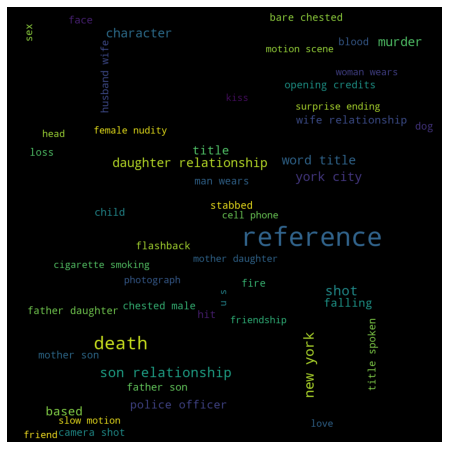

In [17]:
plt.subplots(figsize=(12,12))
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')
words = movie_df['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
      word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=50, stopwords=STOPWORDS, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(8,8)
plt.show()

In [18]:
from collections import Counter
c = Counter(word)
n = 10 
most_common = [key for key, val in c.most_common(n)]
most_common

['murder',
 'death',
 'husband-wife-relationship',
 'violence',
 'flashback',
 'father-son-relationship',
 'blood',
 'title-spoken-by-character',
 'bare-chested-male',
 'friendship']

In [19]:
for j in most_common: 
    movie_df[j] = 0
    
for index, row in movie_df.iterrows():
    for j in most_common:
        if (j in row['keywords']):
           movie_df.loc[index, j] = 1 

#### Last checks:

In [20]:
movie_df.drop(['story_line', 'keywords'], axis = 1, inplace=True)
movie_df.dropna(subset= ['point', 'dollar_budget'], how='any', inplace=True)
movie_df.head()

,title_year,point,runtime,dollar_budget,BlogPage,CompPage,HomePage,release_month,release_day,Drama,...,murder,death,husband-wife-relationship,violence,flashback,father-son-relationship,blood,title-spoken-by-character,bare-chested-male,friendship
movie_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,2001.0,6.4,118.0,0.187416,0,0,0,12.0,25.0,0,...,0,0,0,0,0,0,0,0,0,0
tt0098375,1990.0,4.8,97.0,0.029114,0,0,0,2.0,23.0,0,...,1,1,0,1,1,0,0,1,0,0
tt0098987,1990.0,6.5,104.0,0.105868,0,0,0,7.0,11.0,0,...,1,1,0,0,0,0,0,0,0,0
tt0099005,1990.0,5.8,113.0,0.185269,0,0,0,8.0,10.0,0,...,0,0,0,0,0,0,0,1,0,0
tt0099012,1990.0,6.6,106.0,0.063521,0,0,0,1.0,10.0,0,...,0,0,1,0,1,0,0,1,0,0


# Regressors:

## Random Forest:


#### RandomizedSearchCV for best hyperparameter values:

In [21]:
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 230, num = 8)]
max_depth = [int(x) for x in np.linspace(22, 33, num = 5)]
max_features = ['auto', 'sqrt']
min_samples_split = [5, 10, 15]
min_samples_leaf = [1, 2, 4, 6]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

pprint(random_grid)

{'max_depth': [22, 24, 27, 30, 33],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [5, 10, 15],
 'n_estimators': [150, 161, 172, 184, 195, 207, 218, 230]}


In [22]:
X_train, X_test, y_train, y_test = train_test_split(movie_df.drop('point', axis=1), 
                                                          movie_df['point'], test_size=0.2, random_state=42)
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 10, cv = 10, verbose=2, random_state=42, 
                               n_jobs = -1, scoring='neg_mean_squared_error')
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


{'n_estimators': 218,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 33}

#### Evaluation method utility:

In [23]:
def pae(y_pred, y_true, a, b):
    akbar = len(y_pred)
    count = 0
    for i in range(len(y_pred)):
        target = abs(y_pred[i] - y_true[i])
        if (target >= a) and (target < b):
            count += 1
    return (count/akbar)


def evaluate(y_test, y_pred, y_train, y_train_pred):
    train_acc = 100 - np.mean(100 * (abs(y_train_pred - y_train) / y_train))
    test_acc = 100 - np.mean(100 * (abs(y_pred - y_test) / y_test))
    train_r2 = metrics.r2_score(y_train, y_train_pred)
    test_r2 = metrics.r2_score(y_test, y_pred)
    tr_pae01 = pae(y_train_pred, y_train, 0, 0.5)
    tr_pae12 = pae(y_train_pred, y_train, 0, 1)
    tr_pae23 = pae(y_train_pred, y_train, 0, 2)
    
    ts_pa01 = pae(y_pred, y_test, 0, 0.5)
    ts_pa12 = pae(y_pred, y_test, 0, 1)
    ts_pa23 = pae(y_pred, y_test, 0, 2)
    
    
    train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
    test_mae = metrics.mean_absolute_error(y_test, y_pred)
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    result = pd.DataFrame({
    'Data' : ['Train', 'Test'],
    'Accuracy' : [train_acc, test_acc],
    'R2' : [train_r2, test_r2],
    'MAE' : [train_mae, test_mae],
    'RMSE'   : [train_rmse, test_rmse],
    'PAE(0,0.5)' : [tr_pae01, ts_pa01],
    'PAE(0,1)' : [tr_pae12, ts_pa12],
    'PAE(0,2)' : [tr_pae23, ts_pa23]
    })
    return result

In [24]:
n_est_best = rf_random.best_params_['n_estimators']
min_sp_best = rf_random.best_params_['min_samples_split']
max_f_best = rf_random.best_params_['max_features']
max_d_best = rf_random.best_params_['max_depth']

def split_and_fit(input_df):
    X_train, X_test, y_train, y_test = train_test_split(input_df.drop('point', axis=1), 
                                                          input_df['point'], test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators = n_est_best, min_samples_split = min_sp_best,
                              max_features = max_f_best, max_depth = max_d_best)
    rf.fit(X_train, y_train)
    return evaluate(y_test, rf.predict(X_test), y_train, rf.predict(X_train))

#### Handling ouliers:

Let's try something fun. Here we will check three main methods of handling outliers and their impact on model performance:
* Using Upper and Lower limit for point. Remove all movies that their point is higher or lower than a specific range.

* Using only a Lower limit. Remove all movies that have low budget. We will use budget_cluster and remove the first two groups from.

In [65]:
## Second solution
upper_lim = movie_df['point'].quantile(.96)
lower_lim = movie_df['point'].quantile(.04)
no_outliers = movie_df[(movie_df['point'] < upper_lim) & (movie_df['point'] > lower_lim)]
split_and_fit(no_outliers)

,Data,Accuracy,R2,MAE,RMSE,"PAE(0,0.5)","PAE(0,1)","PAE(0,2)"
0,Train,93.785538,0.654484,0.372636,0.463168,0.718933,0.970981,1.0
1,Test,90.682261,0.258011,0.561806,0.686736,0.519177,0.849392,1.0


Text(0, 0.5, 'Frequency')

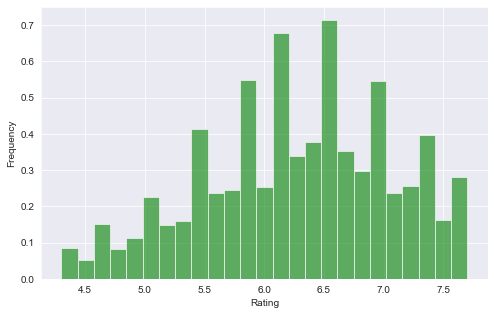

In [66]:
plt.figure(figsize=(8,5))
plt.hist(no_outliers['point'], bins=25, density=True, alpha=0.6, color='g')
plt.xlabel("Rating")
plt.ylabel("Frequency")

#### Removing unimportant columns based on correlation:


We will drop those columns that their correlation with point is less than 1%, this action will result in a smaller dataset and also a mild increase in accuracy:

In [26]:
df_corr = no_outliers.corr()
a_corrlist = df_corr['point'].sort_values(ascending=False)
strong_columns = a_corrlist[abs(a_corrlist) >= 0.01].index.to_list()
no_outliers = no_outliers[strong_columns]
X_train, X_test, y_train, y_test = train_test_split(no_outliers.drop('point', axis=1), 
                                                      no_outliers['point'], test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators = n_est_best, min_samples_split = min_sp_best,
                          max_features = max_f_best, max_depth = max_d_best)
rf.fit(X_train, y_train)
evaluate(y_test, rf.predict(X_test), y_train, rf.predict(X_train))

,Data,Accuracy,R2,MAE,RMSE,"PAE(0,0.5)","PAE(0,1)","PAE(0,2)"
0,Train,93.579547,0.630955,0.385008,0.47868,0.704657,0.962790,1.000000
1,Test,90.748635,0.270076,0.557276,0.68113,0.516370,0.856876,0.999065


## Lasso and Ridge Regressor:

In [27]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [28]:
lasso_params = {'alpha':[0.001, 0.002, 0.005, 0.007 ,0.01, 0.015, 0.02]}
ridge_params = {'alpha':[int(x) for x in np.linspace(10, 100, num = 30)]}

In [29]:
X_train, X_test, y_train, y_test = train_test_split(no_outliers.drop('point', axis=1), 
                                                          no_outliers['point'], test_size=0.2, random_state=42)
lasso = linear_model.Lasso()
lasso_random = RandomizedSearchCV(estimator = lasso, param_distributions = lasso_params, 
                               n_iter = 7, cv = 10, verbose=2, random_state=42, 
                               n_jobs = -1, scoring='neg_mean_squared_error')
lasso_random.fit(X_train, y_train)
lasso_model = lasso_random.best_estimator_


ridge = linear_model.Ridge()
ridge_random = RandomizedSearchCV(estimator = ridge, param_distributions = ridge_params, 
                               n_iter = 10, cv = 10, verbose=2, random_state=42, 
                               n_jobs = -1, scoring='neg_mean_squared_error')
ridge_random.fit(X_train, y_train)
ridge_model = ridge_random.best_estimator_

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


#### Lasso and Ridge Performance without pipeline:

In [30]:
## Lasso:
evaluate(y_test, lasso_model.predict(X_test), y_train, lasso_model.predict(X_train))

,Data,Accuracy,R2,MAE,RMSE,"PAE(0,0.5)","PAE(0,1)","PAE(0,2)"
0,Train,90.702471,0.222575,0.557772,0.694759,0.519541,0.842031,0.998128
1,Test,90.434103,0.207389,0.576768,0.709776,0.504210,0.821328,1.000000


In [31]:
## Ridge:
evaluate(y_test, ridge_model.predict(X_test), y_train, ridge_model.predict(X_train))

,Data,Accuracy,R2,MAE,RMSE,"PAE(0,0.5)","PAE(0,1)","PAE(0,2)"
0,Train,90.696707,0.222360,0.558095,0.694855,0.520477,0.840861,0.998362
1,Test,90.424114,0.206217,0.577415,0.710301,0.507016,0.821328,1.000000


#### Adding pipeline:

In [32]:
lasso_params = {'fit__alpha':[0.001, 0.002, 0.005, 0.007 ,0.01, 0.015, 0.02]}
ridge_params = {'fit__alpha':[int(x) for x in np.linspace(10, 100, num = 30)]}

pipe_lasso = Pipeline([('poly', PolynomialFeatures()),
                 ('fit', linear_model.Lasso())])
lasso_random = RandomizedSearchCV(estimator = pipe_lasso, param_distributions = lasso_params, 
                               n_iter = 10, cv = 10, verbose=2, random_state=42, 
                               n_jobs = -1, scoring='neg_mean_squared_error')
lasso_random.fit(X_train, y_train)
lasso_model = lasso_random.best_estimator_

pipe_ridge = Pipeline([('poly', PolynomialFeatures()),
                 ('fit', linear_model.Ridge())])
ridge_random = RandomizedSearchCV(estimator = pipe_ridge, param_distributions = ridge_params, 
                               n_iter = 10, cv = 10, verbose=2, random_state=42, 
                               n_jobs = -1, scoring='neg_mean_squared_error')
ridge_random.fit(X_train, y_train)
ridge_model = ridge_random.best_estimator_

C:\Users\hoomo\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.7min finished
C:\Users\hoomo\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 966.2747727631747, tolerance: 0.26530341259068574
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished


#### Lasso and Ridge Performance with pipeline:

In [33]:
## Lasso:
evaluate(y_test, lasso_model.predict(X_test), y_train, lasso_model.predict(X_train))

,Data,Accuracy,R2,MAE,RMSE,"PAE(0,0.5)","PAE(0,1)","PAE(0,2)"
0,Train,91.088085,0.289001,0.534574,0.664415,0.536859,0.858413,0.99883
1,Test,90.614276,0.244337,0.564435,0.693035,0.518241,0.837231,1.00000


In [34]:
## Ridge:
evaluate(y_test, ridge_model.predict(X_test), y_train, ridge_model.predict(X_train))

,Data,Accuracy,R2,MAE,RMSE,"PAE(0,0.5)","PAE(0,1)","PAE(0,2)"
0,Train,91.261008,0.314430,0.524043,0.652425,0.547859,0.865668,0.998830
1,Test,90.590588,0.239701,0.565833,0.695158,0.526660,0.839102,0.999065


## SVRs:

### SVR - linear:

In [35]:
from sklearn.svm import SVR

svr_l_params = {'kernel': ['linear'],
                'gamma': [10, 1, 0.1, 0.01, 0.001],
                'C': [0.1, 1, 10, 50]}

X_train, X_test, y_train, y_test = train_test_split(no_outliers.drop('point', axis=1), 
                                                          no_outliers['point'], test_size=0.2, random_state=42)
svr_linear_random = RandomizedSearchCV(estimator = SVR(), param_distributions = svr_l_params, 
                               n_iter = 10, cv = 10, verbose=2, random_state=42, 
                               n_jobs = -1, scoring='neg_mean_squared_error')
svr_linear_random.fit(X_train, y_train)
svr_linear_model = svr_linear_random.best_estimator_
evaluate(y_test, svr_linear_model.predict(X_test), y_train, svr_linear_model.predict(X_train))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


,Data,Accuracy,R2,MAE,RMSE,"PAE(0,0.5)","PAE(0,1)","PAE(0,2)"
0,Train,87.059856,-0.592052,0.809045,0.994222,0.367891,0.660192,0.963492
1,Test,86.669700,-0.651187,0.839423,1.024447,0.351731,0.620206,0.958840


### SVR - RBF:

In [36]:
svr_r_params = {'kernel': ['rbf'],
                'gamma': [10, 1, 0.1, 0.01, 0.001],
                'C': [0.1, 1, 10, 50]}

X_train, X_test, y_train, y_test = train_test_split(no_outliers.drop('point', axis=1), 
                                                          no_outliers['point'], test_size=0.2, random_state=42)
svr_rbf_random = RandomizedSearchCV(estimator = SVR(), param_distributions = svr_r_params, 
                               n_iter = 10, cv = 10, verbose=2, random_state=42, 
                               n_jobs = -1, scoring='neg_mean_squared_error')
svr_rbf_random.fit(X_train, y_train)
svr_rbf_model = svr_rbf_random.best_estimator_
evaluate(y_test, svr_rbf_model.predict(X_test), y_train, svr_rbf_model.predict(X_train))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


,Data,Accuracy,R2,MAE,RMSE,"PAE(0,0.5)","PAE(0,1)","PAE(0,2)"
0,Train,91.498215,0.312924,0.505145,0.653141,0.582729,0.867072,0.998362
1,Test,90.511667,0.224661,0.567190,0.702000,0.521048,0.838167,0.999065


In [37]:
svr_rbf_random.best_params_

{'kernel': 'rbf', 'gamma': 0.01, 'C': 1}

### SVR - Poly:

In [38]:
# svr_p_params = {'kernel': ['poly'],
#                 'gamma': [10, 1, 0.1, 0.01, 0.001],
#                 'C': [0.1, 1, 10]}

X_train, X_test, y_train, y_test = train_test_split(no_outliers.drop('point', axis=1), 
                                                          no_outliers['point'], test_size=0.2, random_state=42)
# svr_poly_random = RandomizedSearchCV(estimator = SVR(), param_distributions = svr_p_params, 
#                                n_iter = 10, cv = 10, verbose=2, random_state=42, 
#                                n_jobs = -1, scoring='neg_mean_squared_error')


# svr_poly_random.fit(X_train, y_train)
# svr_poly_model = svr_poly_random.best_estimator_

# svr_poly_model = SVR(kernel = 'poly', gamma= 0.01, C= 1)
# svr_poly_model.fit(X_train, y_train)
# evaluate(y_test, svr_poly_model.predict(X_test), y_train, svr_poly_model.predict(X_train))

## KNN regressor:

In [39]:
from sklearn.neighbors import KNeighborsRegressor
knn_params = {  'n_neighbors': [int(x) for x in np.linspace(2, 50, num = 20)],
                'weights': ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

X_train, X_test, y_train, y_test = train_test_split(no_outliers.drop('point', axis=1), 
                                                          no_outliers['point'], test_size=0.2, random_state=42)
knn_random = RandomizedSearchCV(estimator = KNeighborsRegressor(), param_distributions = knn_params, 
                               n_iter = 10, cv = 10, verbose=2, random_state=42, 
                               n_jobs = -1, scoring='neg_mean_squared_error')
knn_random.fit(X_train, y_train)
knn_model = knn_random.best_estimator_
evaluate(y_test, knn_model.predict(X_test), y_train, knn_model.predict(X_train))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished


,Data,Accuracy,R2,MAE,RMSE,"PAE(0,0.5)","PAE(0,1)","PAE(0,2)"
0,Train,100.000000,1.000000,0.000000,0.00000,1.000000,1.000000,1.000000
1,Test,90.072851,0.136399,0.600753,0.74088,0.482694,0.792329,0.998129


## Util:

In [40]:
upper_lim = movie_df['point'].quantile(.96)
lower_lim = movie_df['point'].quantile(.04)
no_outliers = movie_df[(movie_df['point'] < upper_lim) & (movie_df['point'] > lower_lim)]

## XGboost:

In [49]:
import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=no_outliers.drop('point', axis=1),label=no_outliers['point'])
X_train, X_test, y_train, y_test = train_test_split(no_outliers.drop('point', axis=1), 
                                                          no_outliers['point'], test_size=0.2, random_state=42)

xgb_params = {  'n_estimators': [int(x) for x in np.linspace(10, 1000, num = 40)],
                'max_depth': [int(x) for x in np.linspace(4, 40, num = 10)],
                'learning_rate ' : [0.0001, 0.001, 0.01, 0.1, 1.0],
                'colsample_bytree' : [0.4, 0.3, 0.2, 0.1],
                'subsample' : [0.5, 0.3, 1]}


xgb_random = RandomizedSearchCV(estimator = xgb.XGBRegressor(), param_distributions = xgb_params, 
                               n_iter = 25, cv = 10, verbose=2, random_state=42, 
                               n_jobs = -1, scoring='neg_mean_squared_error')

xgb_random.fit(X_train, y_train)
xgb_model = xgb_random.best_estimator_

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.9min finished


[09:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [50]:
evaluate(y_test, xgb_model.predict(X_test), y_train, xgb_model.predict(X_train))

,Data,Accuracy,R2,MAE,RMSE,"PAE(0,0.5)","PAE(0,1)","PAE(0,2)"
0,Train,92.120776,0.438043,0.471809,0.590686,0.612450,0.902410,0.999766
1,Test,90.712709,0.261838,0.559423,0.684963,0.513564,0.849392,0.998129


In [43]:
# xgb_random.best_params_
new_params = {'colsample_bytree': 0.4, 'learning_rate ': 1.0,
              'max_depth': 4, 'subsample': 1}
cv_results = xgb.cv(dtrain=data_dmatrix, params=new_params, nfold=10,
      num_boost_round=50,early_stopping_rounds=10,metrics=["rmse", "mae"], as_pandas=True, seed=123)

In [44]:
cv_results.tail(1)

,train-mae-mean,train-mae-std,train-rmse-mean,train-rmse-std,test-mae-mean,test-mae-std,test-rmse-mean,test-rmse-std
24,0.509905,0.002154,0.633271,0.002255,0.549105,0.017383,0.681246,0.016753


In [45]:
# print("Train Accuracy: ", (0.571710 / cv_results.tail(1)['train-mae-mean'].values[0]) * 90.466982)
# print("Test Accuracy: ", (0.572226 / cv_results.tail(1)['test-mae-mean'].values[0]) * 90.503220)

## Gradient Boost:

In [46]:
from sklearn.ensemble import GradientBoostingRegressor
X_train, X_test, y_train, y_test = train_test_split(no_outliers.drop('point', axis=1), 
                                                          no_outliers['point'], test_size=0.2, random_state=42)

gb_params = {  'n_estimators': [int(x) for x in np.linspace(10, 100, num = 20)],
                'max_depth': [int(x) for x in np.linspace(3, 25, num = 10)],
                'learning_rate' : [0.5, 0.04, 0.05, 0.01],
                'min_samples_split' : [1, 2, 5, 10],
                'min_samples_leaf' : [5, 8, 10],
                'max_features' : [int(x) for x in np.linspace(1, X_train.shape[1], num = 20)]}

gb_random = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = gb_params, 
                               n_iter = 30, cv = 10, verbose=2, random_state=42, 
                               n_jobs = -1, scoring='neg_mean_squared_error')

gb_random.fit(X_train, y_train)
gb_model = gb_random.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   48.9s finished


In [47]:
gb_random.best_params_

{'n_estimators': 81,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_features': 22,
 'max_depth': 7,
 'learning_rate': 0.04}

In [48]:
evaluate(y_test, gb_model.predict(X_test), y_train, gb_model.predict(X_train))

,Data,Accuracy,R2,MAE,RMSE,"PAE(0,0.5)","PAE(0,1)","PAE(0,2)"
0,Train,92.411490,0.480301,0.453084,0.568043,0.631875,0.916452,0.999766
1,Test,90.777012,0.270418,0.555067,0.680971,0.517306,0.858746,0.999065
